# Zero-Shot Object Detection with YOLO-World
---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/AILab-CVC/YOLO-World)
[![arXiv](https://img.shields.io/badge/arXiv-2401.17270-b31b1b.svg)](https://arxiv.org/abs/2401.17270)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/X7gKBGVz4vs)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/what-is-yolo-world/)

YOLO-World was designed to solve a limitation of existing zero-shot object detection models: speed. Whereas other state-of-the-art models use Transformers, a powerful but typically slower architecture, YOLO-World uses the faster CNN-based YOLO architecture.

According to the paper YOLO-World reached between 35.4 AP with 52.0 FPS for the large version and 26.2 AP with 74.1 FPS for the small version. While the V100 is a powerful GPU, achieving such high FPS on any device is impressive.

![visualization results of referring object detection](https://storage.googleapis.com/com-roboflow-marketing/supervision/cookbooks/yolo-world-visualization-results-of-referring-object-detection.png)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sat Mar  8 03:00:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.03                 Driver Version: 561.03         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
| 31%   35C    P8             17W /  285W |    1446MiB /  12282MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

t:\Projects\yolo-world


## Install required packages

In this guide, we utilize two Python packages: `inference`, for executing zero-shot object detection using YOLO-World, and `supervision`, for post-processing and visualizing the detected objects.

In [3]:
!pip install inference-gpu[yolo-world]

  Using cached inference_gpu-0.40.0-py3-none-any.whl.metadata (24 kB)
  Using cached aiortc-1.9.0-cp38-abi3-win_amd64.whl.metadata (5.6 kB)
  Using cached APScheduler-3.11.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached asyncua-1.1.5-py3-none-any.whl.metadata (9.5 kB)
  Using cached Cython-3.0.12-cp312-cp312-win_amd64.whl.metadata (3.6 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached fastapi-0.110.3-py3-none-any.whl.metadata (24 kB)
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached opencv_contrib_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached pillow-10.4.0-cp312-cp312-win_amd64.whl.metadata (9.3 kB)
  Using cached prometheus_fastapi_instrumentator-6.0.0-py3-none-any.whl.metadata (13 kB)
  Using cached redis-5.0.8-py3-none-any.whl.metadata (9.2 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata 


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install -q supervision

## Imports

In [5]:
import cv2
import supervision as sv

from tqdm import tqdm
from inference.models import YOLOWorld

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\pmkha\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


ModelDependencyMissing: Your `inference` configuration does not support PaliGemma model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support Florence2 model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support Qwen2.5-VL model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support OWLv2 model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configur

## Download example data

In [9]:
# !wget -P {HOME} -q https://media.roboflow.com/notebooks/examples/dog.jpeg
# !wget -P {HOME} -q https://media.roboflow.com/supervision/cookbooks/yellow-filling.mp4

# Windows
!curl -o dog.jpeg https://media.roboflow.com/notebooks/examples/dog.jpeg
!curl -o yellow-filling.mp4 https://media.roboflow.com/supervision/cookbooks/yellow-filling.mp4

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 16  103k   16 17355    0     0   142k      0 --:--:-- --:--:-- --:--:--  143k
100  103k  100  103k    0     0   563k      0 --:--:-- --:--:-- --:--:--  565k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 54 1957k   54 1071k    0     0  1193k      0  0:00:01 --:--:--  0:00:01 1194k
100 1957k  100 1957k    0     0  1997k      0 --:--:-- --:--:-- --:--:-- 1999k


In [ ]:
SOURCE_IMAGE_PATH = "dog.jpeg"

**NOTE:** If you want to run the cookbook using your own file as input, simply upload video to Google Colab and replace `SOURCE_IMAGE_PATH` and `SOURCE_VIDEO_PATH` with the path to your file.

## Run Object Detection

The Inference package provides the YOLO-World model in three versions: `S`, `M`, and `L`. You can load them by defining model_id as `yolo_world/s`, `yolo_world/m`, and `yolo_world/l`, respectively. The `ROBOFLOW_API_KEY` is not required to utilize this model.







In [11]:
model = YOLOWorld(model_id="yolo_world/l")

Creating inference sessions


CLIP model loaded in 29.48 seconds


YOLO-World is a zero-shot model, enabling object detection without any training. You only need to define a prompt as a list of classes (things) you are searching for.

In [12]:
classes = ["person", "backpack", "dog", "eye", "nose", "ear", "tongue"]
model.set_classes(classes)

We perform detection on our sample image. Then, we convert the result into a [`sv.Detections`](https://supervision.roboflow.com/latest/detection/core/) object, which will be useful in the later parts of the cookbook.

In [13]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image)
detections = sv.Detections.from_inference(results)

The results we've obtained can be easily visualized with [`sv.BoundingBoxAnnotator`](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.BoundingBoxAnnotator) and [`sv.LabelAnnotator`](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.LabelAnnotator). We can adjust parameters such as line thickness, text scale, line and text color allowing for a highly tailored visualization experience.

In [14]:
BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


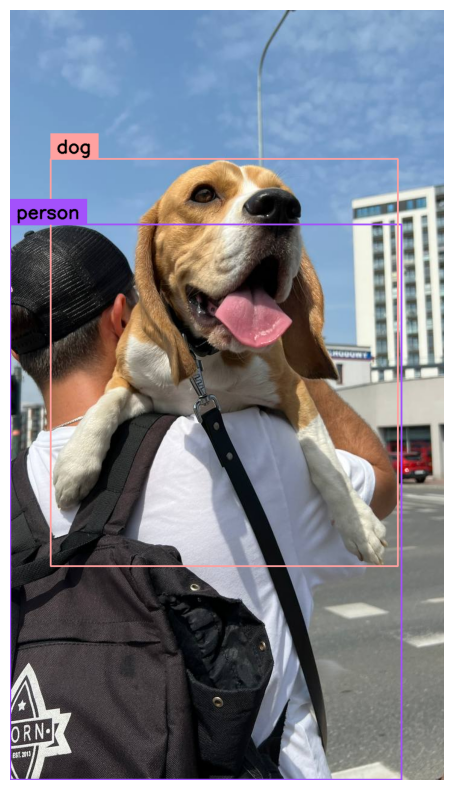

In [15]:
annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

## Adjusting Confidence Level

Note that many classes from our prompt were not detected. This is because the default confidence threshold in Inference is set to `0.5`. Let's try significantly lowering this value. We've observed that the confidence returned by YOLO-World is significantly lower when querying for classes outside the [COCO](https://universe.roboflow.com/microsoft/coco) dataset.

In [16]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.003)
detections = sv.Detections.from_inference(results)

By default, `sv.LabelAnnotator` displays only the names of objects. To also view the confidence levels associated with each detection, we must define custom `labels` and pass them to `sv.LabelAnnotator`.

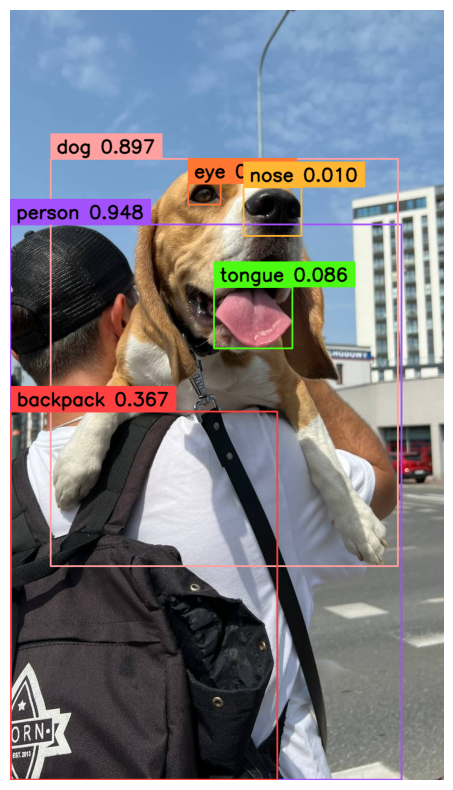

In [17]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))

## Using Non-Max Suppression (NMS) to Eliminate Double Detections

To eliminate duplicates, we will use [Non-Max Suppression (NMS)](https://blog.roboflow.com/how-to-code-non-maximum-suppression-nms-in-plain-numpy). NMS evaluates the extent to which detections overlap using the Intersection over Union metric and, upon exceeding a defined threshold, treats them as duplicates. Duplicates are then discarded, starting with those of the lowest confidence. The value should be within the range `[0, 1]`. The smaller the value, the more restrictive the NMS.







In [154]:
SOURCE_IMAGE_PATH = "crosswalk.png"
classes = ["car tail light"]
model.set_classes(classes)

image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.0005)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

labels = ['car tail light 0.0037']


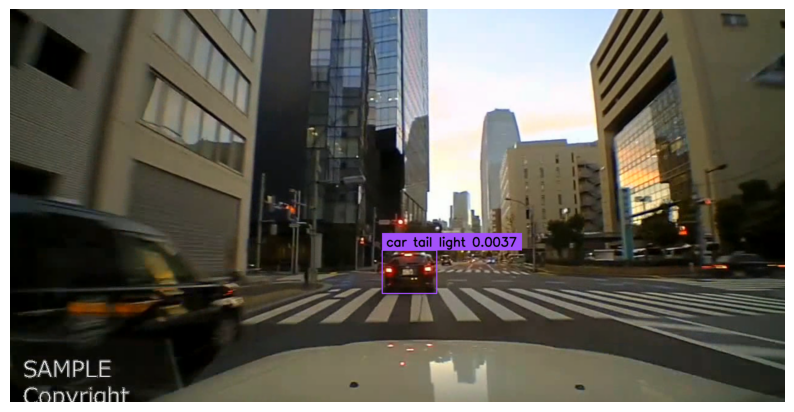

In [155]:
labels = [
    f"{classes[class_id]} {confidence:0.4f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]
print(f"labels = {labels}")

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))

## Video Processing

The [`get_video_frames_generator`](https://supervision.roboflow.com/latest/utils/video/#supervision.utils.video.get_video_frames_generator) enables us to easily iterate over video frames. Let's create a video generator for our sample input file and display its first frame on the screen.

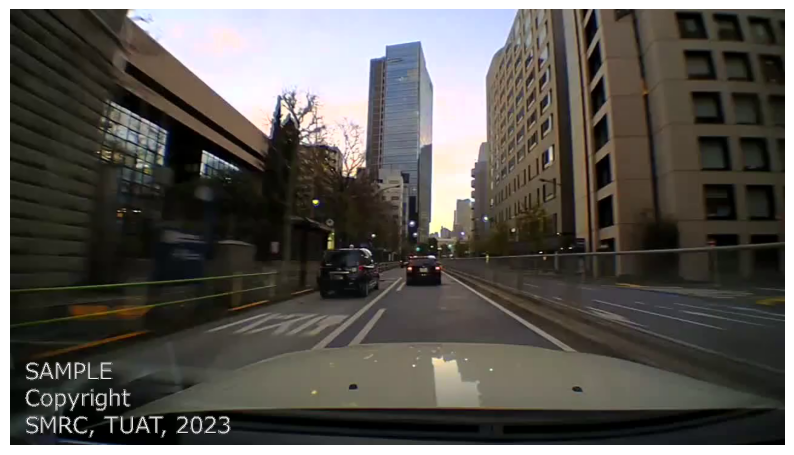

In [86]:
SOURCE_VIDEO_PATH = "sample_741376 copy.mp4"
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(generator)

sv.plot_image(frame, (10, 10))

Let's update our list of classes. This time we are looking for `yellow filling`. The rest of the code performing detection, filtering and visualization remains unchanged.

In [87]:
classes = ["bicycle", "crosswalk", "turning arrow", "zebra crossing"] # 
model.set_classes(classes)

In [99]:
results = model.infer(frame, confidence=0.001)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

print(detections)

Detections(xyxy=array([[     798.21,       398.7,       808.8,      424.63]]), mask=None, confidence=array([  0.0020783]), class_id=array([0]), tracker_id=None, data={'class_name': array(['bicycle'], dtype='<U7')}, metadata={})


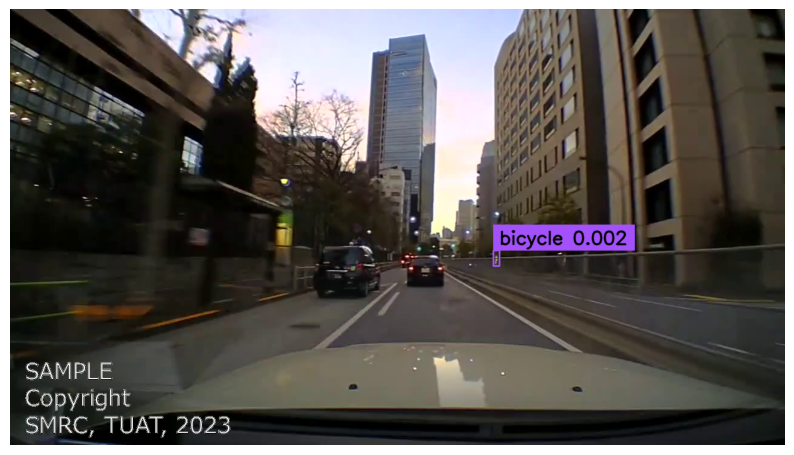

In [100]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = frame.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))

## Filtering Detectuions by Area

Our prompt allowed us to locate all filled holes, but we also accidentally marked the entire high-level element. To address this issue, we'll filter detections based on their relative area in relation to the entire video frame. If a detection occupies more than 10% of the frame's total area, it will be discarded.

We can use [`VideoInfo.from_video_path`](https://supervision.roboflow.com/develop/utils/video/#supervision.utils.video.VideoInfo) to learn basic information about our video, such as duration, resolution, or FPS.

In [91]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_info

VideoInfo(width=1280, height=720, fps=14, total_frames=223)

Knowing the frame's resolution allows us to easily calculate its total area, expressed in pixels.

In [92]:
width, height = video_info.resolution_wh
frame_area = width * height
frame_area

921600

On the other hand, by using [`sv.Detections.area`](https://supervision.roboflow.com/develop/detection/core/#supervision.detection.core.Detections.area) property, we can learn the area of each individual bounding box.

In [93]:
results = model.infer(frame, confidence=0.002)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)
detections.area

array([], dtype=float32)

Now, we can combine these two pieces of information to construct a filtering condition for detections with an area greater than 10% of the entire frame.

In [94]:
(detections.area / frame_area) < 0.10

array([], dtype=bool)

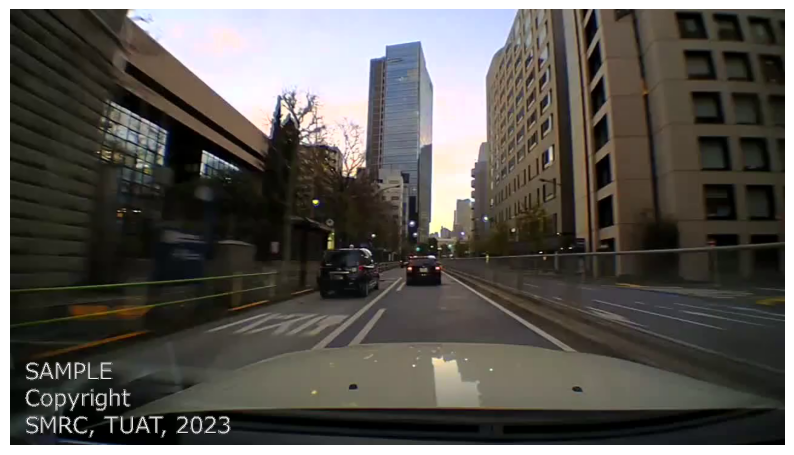

In [95]:
detections = detections[(detections.area / frame_area) < 0.10]

annotated_image = frame.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

## Final Result

Finally, we are ready to process our entire video. Now in truth we can appreciate the speed of YOLO-World.

In [156]:
#SOURCE_VIDEO_PATH = "yellow-filling.mp4"
SOURCE_VIDEO_PATH = "sample_741376 copy.mp4"
TARGET_VIDEO_PATH = "sample_741376output.mp4"


In [ ]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

basic_classes = ["car", "red traffic light", "green traffic light", "bicycle", "pedestrian", "pedestrian light"]
detailed_classes = ["street arrow", "street right arrow", "street left arrow", "car tail light", "street no parking sign"]


width, height = video_info.resolution_wh
frame_area = width * height
frame_area

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        # basic class
        model.set_classes(basic_classes)
        results = model.infer(frame, confidence=0.2)
        detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)
        # detections = detections[(detections.area / frame_area) < 0.10]

        labels = [
            f"{basic_classes[class_id]} {confidence:0.3f}"
            for class_id, confidence
            in zip(detections.class_id, detections.confidence)
        ]
        
        annotated_frame = frame.copy()
        annotated_frame = BOUNDING_BOX_ANNOTATOR.annotate(annotated_frame, detections)
        annotated_frame = LABEL_ANNOTATOR.annotate(annotated_frame, detections, labels=labels)
        
        
        # Detailes class
        model.set_classes(detailed_classes)
        results = model.infer(frame, confidence=0.004)
        detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)
        # detections = detections[(detections.area / frame_area) < 0.10]

        labels = [
            f"{detailed_classes[class_id]} {confidence:0.3f}"
            for class_id, confidence
            in zip(detections.class_id, detections.confidence)
        ]
        
        #annotated_frame = frame.copy()
        annotated_frame = BOUNDING_BOX_ANNOTATOR.annotate(annotated_frame, detections)
        annotated_frame = LABEL_ANNOTATOR.annotate(annotated_frame, detections, labels=labels)
        
        sink.write_frame(annotated_frame)

  0%|          | 0/223 [00:00<?, ?it/s]

100%|██████████| 223/223 [02:14<00:00,  1.66it/s]
